# Data processing pipeline
### from raw data to numeric ML applicable features

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
import string

In [4]:
# load datasets
meta = pd.read_parquet(r"/Users/luis/Downloads/02  Fragment intensity prediction/Metadata/metadata.parquet", engine ='auto')
data = pd.read_parquet(r'/Users/luis/Downloads/02  Fragment intensity prediction/Fragment_Intensity.parquet', engine = 'auto')

# merge dataframes
merged = data.merge(meta, how='inner', on=['scan_number', 'raw_file'])

merged.sort_values(by=['scan_number', 'raw_file']) #combination of scan number and raw file corresponds to one spectrum

peptide_sequence  scan_number  \
71994435  GAC[UNIMOD:4]GSC[UNIMOD:4]GGSKGGC[UNIMOD:4]GSC...          984   
71994436  GAC[UNIMOD:4]GSC[UNIMOD:4]GGSKGGC[UNIMOD:4]GSC...          984   
71994437  GAC[UNIMOD:4]GSC[UNIMOD:4]GGSKGGC[UNIMOD:4]GSC...          984   
71994438  GAC[UNIMOD:4]GSC[UNIMOD:4]GGSKGGC[UNIMOD:4]GSC...          984   
71994439  GAC[UNIMOD:4]GSC[UNIMOD:4]GGSKGGC[UNIMOD:4]GSC...          984   
...                                                     ...          ...   
52576287                                           DFLELFFR        83251   
52576288                                           DFLELFFR        83251   
52576289                                           DFLELFFR        83251   
52576290                                           DFLELFFR        83251   
52576291                                           DFLELFFR        83251   

                                                   raw_file ion_type  no  \
71994435  01866a_GA1-TUM_second_pool_93_03_01-2xIT_2xHCD...        b   3   
71994436  01866a_GA1-TUM_second_pool_93_03_01-2xIT_2xHCD...        y   2   
71994437  01866a_GA1-TUM_second_pool_93_03_01-2xIT_2xHCD...        b   4   
71994438  01866a_GA1-TUM_second_pool_93_03_01-2xIT_2xHCD...        y   3   
71994439  01866a_GA1-TUM_second_pool_93_03_01-2xIT_2xHCD...        y   4   
...                                                     ...      ...  ..   
52576287  02208a_GA10-TUM_second_addon_10_01_01-2xIT_2xH...        b   5   
52576288  02208a_GA10-TUM_second_addon_10_01_01-2xIT_2xH...        y   5   
52576289  02208a_GA10-TUM_second_addon_10_01_01-2xIT_2xH...        b   6   
52576290  02208a_GA10-TUM_second_addon_10_01_01-2xIT_2xH...        y   6   
52576291  02208a_GA10-TUM_second_addon_10_01_01-2xIT_2xH...        b   7   

            intensity  precursor_charge  
71994435  1126.457397                 3  
71994436    49.602764                 3  
71994437   258.964722                 3  
71994438    32.950253                 3  
71994439   244.449448                 3  
...               ...               ...  
52576287  1137.181030                 2  
52576288  2235.011719                 2  
52576289   845.307434                 2  
52576290  2403.855469                 2  
52576291   429.141510                 2  

[74702711 rows x 7 columns]

## Modifications

All C amino acids have UNIMOD:4
There is no UNIMOD:4 on non-C amino acids
Not all M amino acids have UNIMOD:35
There is no UNIMOD:35 on non-M amino acids

In [5]:
copy = merged.copy()

# scale intensities by max intensities of each spectrum
max_intensities = copy.groupby(['raw_file', 'scan_number']).transform('max')
copy['normalized_intensity']=copy['intensity'] / max_intensities['intensity']

copy=copy.drop('intensity', axis=1)

In [6]:
# longest sequence has length 30
max_length = 30

In [7]:
grouped = copy.groupby(['peptide_sequence','raw_file', 'scan_number', 'precursor_charge'])

# merge ion type, number, normalized intensity columns into 'fragment_ions' column
# now every MS scan contains the full spectrum in the fragment ions column (some scans contain the same sequences)
def extract(group):
    fragments = list(zip(group['ion_type'], group['no'], group['normalized_intensity']))
    return fragments

df = grouped.apply(extract).to_frame()

df = df.reset_index()

df.columns=['peptide_sequence', 'raw_file', 'scan_number', 'precursor_charge', 'fragment_ions']

df = df.sort_values(by=['scan_number', 'raw_file'])

In [8]:
# convert fragment ions column into numerical arrays where the position of an intensity value corresponds to its
# ion type and number. B ions sit in array slots 0-28, y ions in slots 29-57. So e.g. the value of the b4 ion is 
# found in array slot 3, y28 in sot 56 etc.

intensity_vectors = []
for index, row in df.iterrows():
    fragment_ions = row['fragment_ions']
    intensities = np.full((max_length-1) * 2, -1.0)
    intensities[0:len(row['peptide_sequence'])] = 0
    intensities[29:29+len(row['peptide_sequence'])] = 0
    for triplet in fragment_ions:
        ion_type = triplet[0]
        number = triplet[1]
        intensity = triplet[2]
        if ion_type == 'y':
            vector_index = number + 28
        else: 
            vector_index = number-1
        vector_index = int(vector_index)
        intensities[vector_index] = float(intensity)
        
    intensity_vectors.append(intensities)

df['intensity_vectors'] = intensity_vectors

In [9]:
df = df.reset_index()
sequences = df['peptide_sequence'].astype(str).tolist()

In [10]:
kod = df.copy() # copy for safety (I don't know why I named it kod)

In [11]:
# handling modifications: UNIMOD:4 can be ignored -> removed

sequences_without_UNIMOD_4 = []

for sequence in sequences:
    modified_sequence = re.sub(r'\[UNIMOD:4\]', '', sequence)
    sequences_without_UNIMOD_4.append(modified_sequence)

# UNIMOD:35 is on some Ms -> modified Ms are replaced by 'O'
    
sequences_with_O = []

for sequence in sequences_without_UNIMOD_4:
    modified_sequence = sequence.replace('M[UNIMOD:35]', 'O')
    sequences_with_O.append(modified_sequence)

kod['peptide_sequence']= sequences_with_O

In [12]:
# encode the sequences into arrays of integers through a simple approach: A -> 1, B -> 2 etc.

# map letters to numbers
letter_to_number = {letter: str(index + 1) for index, letter in enumerate(string.ascii_uppercase)}


def encode_sequence(sequence):
    encoded_sequence = []
    for letter in sequence:
        encoded_sequence.append(int(letter_to_number.get(letter)))
    return encoded_sequence

kod['encoded_peptide_sequence'] = kod['peptide_sequence'].apply(encode_sequence)

In [13]:
# convert fragment ions column into numerical arrays where the position of an intensity value corresponds to its
# ion type and number. B ions sit in array slots 0-28, y ions in slots 29-57. So e.g. the value of the b4 ion is 
# found in array slot 3, y28 in sot 56 etc.

intensity_vectors = []
for index, row in kod.iterrows():
    fragment_ions = row['fragment_ions']
    intensities = np.full((max_length-1) * 2, -1.0)
    intensities[0:len(row['peptide_sequence'])] = 0
    intensities[29:29+len(row['peptide_sequence'])] = 0
    for triplet in fragment_ions:
        ion_type = triplet[0]
        number = triplet[1]
        intensity = triplet[2]
        if ion_type == 'y':
            vector_index = number + 28
        else: 
            vector_index = number-1
        vector_index = int(vector_index)
        intensities[vector_index] = float(intensity)
        
    intensity_vectors.append(intensities)

kod['intensity_vectors'] = intensity_vectors

In [14]:
# I found out that there were indeed many cases of duplicate sequences in train and test data after Professor Wilhelm advised me to check,
# so I took this approach of grouping equal sequences and shuffling those groups, while keeping the rows in the group together

kod['group_id'] = kod['peptide_sequence'].rank(method = 'dense').astype(int)

unique_group_ids = kod['group_id'].unique()

np.random.shuffle(unique_group_ids)

# map group_id to shuffled unique_group_ids
id_shuff_map = dict(zip(kod['group_id'].unique(), unique_group_ids))

# Apply the mapping 
kod['shuffled_group_id'] = kod['group_id'].map(id_shuff_map)

# Sort DataFrame based on 'shuffled_group_id' to shuffle the group order
final_df = kod.sort_values(by=['shuffled_group_id'])

final_df.reset_index(drop=True, inplace=True)

In [15]:
# pad encoded sequences
sequences_array_f = np.array([seq + [-1] * (max_length - len(seq)) for seq in final_df['encoded_peptide_sequence']])

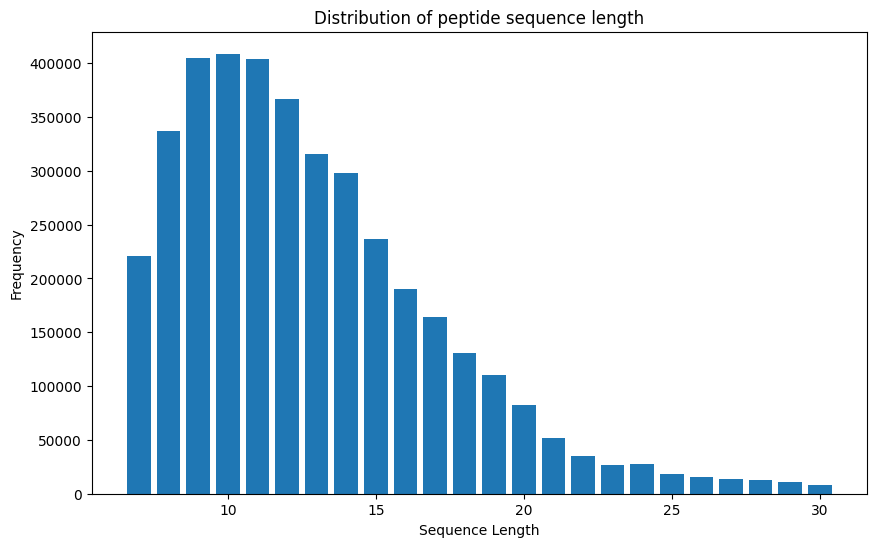

In [16]:
# Compute the length of each sequence and store it in a new column.
final_df['sequence_length'] = final_df['peptide_sequence'].apply(len)

# Calculate the frequency of sequences with each unique length.
sequence_length_counts = final_df['sequence_length'].value_counts().sort_index()

# Create a bar plot.
plt.figure(figsize=(10, 6))
plt.bar(sequence_length_counts.index, sequence_length_counts.values)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of peptide sequence length')
plt.show()

In [17]:
# combine encoded sequences and precursor charge for input data
precursor_cha = final_df['precursor_charge'].tolist()
X_f = np.column_stack((sequences_array_f, precursor_cha))

# intensity vectors for output data
y_f = np.array(final_df['intensity_vectors'].tolist())

In [ ]:
np.save('X_final.npy', X_f)

In [ ]:
np.save('y_final.npy', y_f)